In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
from scipy.special import expit
from scipy.optimize import fmin, minimize
import glob as glob
import matplotlib
matplotlib.style.use('ggplot')

# .py
%load_ext autoreload
%autoreload 2
import weather_humidity_alphas, weather_humidity_costs, prediction_humidity, model_02, validate

running model_02
getting cost from nweek ahead
getting bounded alphas with params for avgrh...
done getting alphas ...
prediction for humidity


In [2]:
def split_data(data):
    train_mask = (data.index < "2011")
    train = data[train_mask]
    test_mask = (data.index > "2011")
    test = data[test_mask]
    return train, test

In [3]:
all_weather = pd.read_csv("weather01-16.csv")

In [4]:
cm_weather = all_weather[all_weather.stn_name == "Chiang Mai"]
cm_weather.index = pd.DatetimeIndex(cm_weather.date)
mask = (cm_weather.index > "2003") & (cm_weather.index < "2016")
cm_weather = cm_weather[mask]

provinces_df = pd.read_csv("all-dengues.csv")
provinces_df.index = pd.DatetimeIndex(provinces_df.date)
provinces_df = provinces_df.drop(['date','date.1'],axis=1)
cm_dengues = provinces_df[provinces_df['จังหวัด'] == 'ChiangMai'].resample('W').size()
cm_dengues_df = pd.DataFrame(cm_dengues,columns=['cases'])

In [5]:
cm_avg_weather = cm_weather[['avgrh','dday','meantemp']].resample('W').mean()
cm_avg_weather['rain'] = cm_weather[['rain']].resample('W').sum() # cumulative rainfall
cm_dengues_weather = pd.concat([cm_avg_weather,cm_dengues_df[:-52]],axis=1)

cm_dengues_weather_split = split_data(cm_dengues_weather)
cm_dengues_train, cm_dengues_test = cm_dengues_weather_split[0], cm_dengues_weather_split[1]

In [10]:
cm_dengues_train.cases.head()

date
2003-01-05    1
2003-01-12    2
2003-01-19    5
2003-01-26    0
2003-02-02    2
Freq: W-SUN, Name: cases, dtype: int64

In [26]:
def make_line(start_week,real,predictions,title,x_axis,y_axis,
              real_legend='Real',predict_legend='Prediction'):
    plt.figure(figsize=(12,6))
    plt.plot(range(len(real)),real,'-r',label=real_legend)
    plt.plot(range(start_week,len(predictions)+start_week),predictions,'-k',label=predict_legend,alpha=0.4)
    plt.axvline(start_week)
    plt.text((start_week*2)+10,300,'Prediction Start',horizontalalignment='center',verticalalignment='center')
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.legend()
    plt.title(title)
    
def plot_all_predictions(LAG, real, train, province, nweeks_to_predict, all_predictions):
    
    plt.figure(figsize=(13,6))
    plt.plot(range(len(real)),real.cases,label='real')
    graph_title = "%s's Dengue Prediction with Weather Data"%province
    plt.title(graph_title)
    for i in range(len(all_predictions)):
        cur_week_guess = nweeks_to_predict[i]
        start_predict_week = LAG+(cur_week_guess-1)
        predicted_cases = all_predictions[i]
        x_weeks = range(start_predict_week,len(predicted_cases)+start_predict_week)
        line_label = "%d week guess"%cur_week_guess
        plt.plot(x_weeks,predicted_cases,label=line_label,alpha=0.8)
    
    seperate_train_test(real,train)
    plt.axvline(LAG)
    plt.text((LAG*2)+10,300,'Prediction Start',horizontalalignment='center',verticalalignment='center')
    plt.xlabel("# week starting 2003")
    plt.ylabel("Dengue cases")
    plt.legend()
#     plt.savefig("16-lags-16-weeks-9-temp-wks-chiangmai-00.png")
    
def seperate_train_test(all_data,train_data):
    plt.axvspan(0, len(train_data), color='blue', alpha=0.1)
    plt.text((len(train_data)/2)-25,700,'Train Period',size=16)
    plt.axvline(len(train_data)+1,linewidth=0.5, color='green')
    plt.text(len(train_data)+20,700,'Test Period',size=16)
    plt.axvspan(len(train_data)+1, len(all_data), color='green', alpha=0.1)
    
def show_predictions(params, real, train, province, ws):
    LAG, TEMPERATURE_WEEKS, RAIN_WEEKS, AVGRH_WEEKS = params[0], params[1], params[2], params[3]
    
    predictions_to_plot = prediction_humidity.get_predictions(
        LAG, 
        TEMPERATURE_WEEKS,
        RAIN_WEEKS,
        AVGRH_WEEKS,
        real,
        ws,
        province)
    
    plot_all_predictions(LAG, 
                         real,
                         train,
                         province,
                         [1,2,4,8,16],
                         predictions_to_plot)
    
    

In [36]:
import multiprocessing as mp
from multiprocessing import Process, Queue

# Define an output queue
output = Queue()

ws_csv = np.array(pd.read_csv("best-with-19-lags-9-temps-15-rains-ws-2nd-iter-model-a.csv").T)[0]
    
def validation(LAG, TEMPERATURE_WEEKS, RAIN_WEEKS, AVGRH_WEEKS, train, real, output):
                                    # get_alphas takes 4 args, if theres no input csv
    alphas = weather_humidity_alphas.get_alphas(
        LAG, 
        TEMPERATURE_WEEKS, 
        RAIN_WEEKS, 
        AVGRH_WEEKS,
        train, 
        ws_csv)
                                    # get_predictions takes 6 args
    predictions_to_validate = prediction_humidity.get_predictions(
        LAG, 
        TEMPERATURE_WEEKS, 
        RAIN_WEEKS, 
        AVGRH_WEEKS, 
        real, 
        alphas.x, 
        "CM")
                                    # get_validations takes 3 argsg
    validated_result = validate.get_validations(
        LAG, 
        predictions_to_validate, 
        real)
    
    output.put((AVGRH_WEEKS,validated_result,alphas.x)) # add in ws as well alphas.x


In [38]:
%%time
# Setup a list of processes that we want to run
train = cm_dengues_train
real = cm_dengues_weather
processes = [Process(target=validation, args=(19, 9, 15, weeks, train, real, output)) for weeks in range(12,16)]
print ws_csv

# Run processes
for p in processes:
    p.start()

# Exit the completed processes
for p in processes:
    p.join()

# Get process results from the output queue
results = [output.get() for p in processes]

print(results)

[  3.13776391e-01   0.00000000e+00   0.00000000e+00   3.29495448e-10
   0.00000000e+00   1.25821399e-09   1.39125455e-11   2.78983267e-09
   2.47468734e-08   2.37904277e-08   4.31859909e-09   2.88204188e-07
   2.12238380e-09   1.00606506e-01   1.07700343e-02   8.52753914e-06
   8.15353478e-08   5.86827040e-08   4.23270610e-07   4.46686401e-01
   2.15456824e+00   7.94325088e+00   2.95500487e-01   5.30912415e-02
  -8.41536677e-03  -4.08655001e-02  -2.68498636e-02  -1.28606933e-02
  -1.87707278e-02   3.66075072e-03   3.33845242e-03  -8.97952259e-03
   5.16566100e-02   2.94477899e-04   3.24280573e-05  -1.72639614e-05
   1.05907159e-04  -3.56382051e-05   8.93740573e-06   7.47903048e-05
   4.05671216e-05   3.61448232e-05   2.25448859e-05  -2.16391626e-05
  -2.50377181e-05  -1.43404700e-05   2.16046300e-06  -5.82294412e-06]
61
bnds 19 61
LAG, TEMP, RAIN, AVGRH 19 9 15 12
ws_csv
prev_ws 48
62
all_prev_ws 61
LAG, TEMP, RAIN, AVGRH 19 9 15 13
bnds 19 62
ws_csv
prev_ws 48
all_prev_ws 62
ws_csv
bn

In [39]:
def get_best(validations):

    all_score = []
    for i in range(len(validations)):
        cur_score = validations[i][1] # since idx 1 is validated results 
        week_16th_pred_score = cur_score[-1] # check with the furthest guess
        all_score.append(week_16th_pred_score)
    min_score_idx = np.argmin(all_score)
    return validations[min_score_idx]
        
    
best_param = get_best(results)
pd.DataFrame(best_param[2]).to_csv("best-with-humidity-but-needs-renaming-2nd-iter.csv",index=False)

In [40]:
print best_param


(15, [161.66137673635103, 271.92676975548602, 503.56778470015297, 783.44896600168966, 1295.2327912091016], array([  3.13733317e-01,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   2.12626405e-09,   1.11643708e-09,
         4.94298960e-09,   4.10480558e-09,   1.05490369e-07,
         3.72021485e-09,   1.00064229e-01,   1.37823597e-02,
         1.08434144e-05,   1.00271237e-07,   6.53966088e-08,
         4.51025634e-07,   4.46427334e-01,   2.15479642e+00,
         7.94761032e+00,   2.95579765e-01,   5.31156060e-02,
        -8.40817495e-03,  -4.09192324e-02,  -2.68355903e-02,
        -1.28968067e-02,  -1.87566397e-02,   3.63401406e-03,
         3.29396075e-03,  -9.08184320e-03,   5.16621081e-02,
        -1.13449757e-05,  -1.01580580e-06,   4.19730450e-08,
        -2.84361119e-06,   1.08978435e-07,   2.33867039e-08,
        -2.55041623e-07,   1.03881172e-07,   6.75591086e-08,
         1.89015912e-09,  -4.20464782e-

In [31]:
ws = np.array(pd.read_csv("best-with-humidity-but-needs-renaming-2nd-iter.csv").T)[0]
len(ws)

50

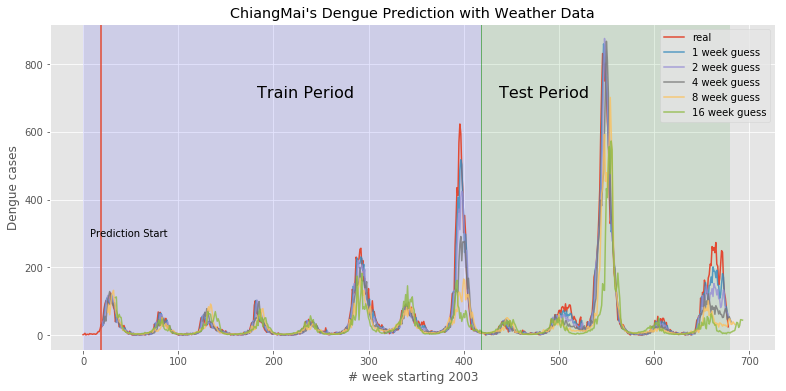

In [28]:
ws = np.array(pd.read_csv("best-with-19-lags-9-temps-15-rains-1-humidity-ws-2nd-iter-model-a.csv").T)[0]
# ww = best_param[2]
real = cm_dengues_weather
train = cm_dengues_train
# show_predictions([20,14,14], real, "ChiangMai", ww)
show_predictions([19,9,15,1], real, train, "ChiangMai", ws)

In [68]:
print ws
print ws[21:23]
# a = prediction.get_predictions(19, 10, 15, real, ws, "CM")
# print validate.get_validations(19,a,real)

[  3.21054441e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   3.06743893e-10   0.00000000e+00   4.91407915e-03
   1.43409511e-09   1.89011211e-08   3.11351051e-10   6.40373267e-08
   4.85527645e-03   1.04118796e-01   4.05540896e-03   2.49841382e-05
   7.94461642e-08   1.96793807e-07   1.20570113e-07   4.51518575e-01
   2.08551264e+00   7.88858736e+00   2.78996285e-01   5.46502177e-02
  -8.64375449e-03  -3.96804634e-02  -2.59688551e-02  -1.38771312e-02
  -1.73065055e-02   1.22372078e-03   2.01429506e-03  -1.34128787e-02
   1.18130553e-02   5.78498717e-02  -6.62364528e-04   1.05350738e-05
   2.69878102e-04  -6.71625623e-05  -2.37068034e-04  -3.23881804e-04
  -4.33580193e-04  -5.11991776e-05  -3.58679531e-05  -4.01191685e-05
  -1.04682886e-06  -1.27993349e-05  -1.01790769e-04   1.28556842e-04
  -4.08379936e-05]
[ 7.88858736  0.27899628]


In [27]:
# pd.DataFrame(best_param[2]).to_csv("best-with-19-lags-10-temps-14-rains-ws-1st-iter-model-a.csv",index=False)
# np.array(pd.read_csv("best-for-19-lags-ws-3rd-iter.csv").T)[0]

In [32]:
chosen_ws = glob.glob("best-*.csv")
for ws_set_file in chosen_ws:
    ws_set = np.array(pd.read_csv(ws_set_file).T)[0]
#     print ws_set_file
    LAG = int(ws_set_file[9:11])
    to_validate = prediction.get_predictions(LAG, 9, 10, real, ws_set)
    print "LAG %d"%LAG,validate.get_validations(LAG, to_validate, real)

LAG 23 [205.82624824351581, 374.86547851071168, 726.02637891644849, 1284.8735497820055, 1627.4597425170004]
LAG 21 [166.85156662968512, 292.0898130079363, 564.366573591867, 1035.0747400189584, 1527.0827702830245]
LAG 22 [168.91992707974032, 294.43310789395724, 581.26512237641293, 1094.9170235354613, 1583.9765963384611]
LAG 19 [166.58144315243547, 288.90438923758734, 543.77910579020795, 947.7903870066549, 1391.3705312824545]


In [147]:
# # pd.DataFrame(best_param[2]).to_csv("best-for-18-lags-ws.csv",index=False)

# lg = [16,17,18,20,22]
# a = np.array(pd.read_csv("best-for-18-lags-ws.csv").T)[0]

# # for i in lg:
# #     if i == len(a):
# #         arr = a
# #         print len(arr)
# #     elif i < len(a):
# #         arr = a[:-(18-i)]
# #         print len(arr)
# #     else:
# #         mean_val = 1/float(i)
# #         arr = np.append(a,[mean_val]*(i-len(a)))
# #         print arr
        
# def ws_helper(LAG, ws, 18):
#     n_ws = len(ws)
#     if LAG == n_ws:
#         print "eq"
#         arr = ws[:LAG+1]
#     elif LAG < n_ws:
#         print "les"
#         arr = ws[:-(n_ws - LAG + 1)]
#     else:
#         print "else"
#         tail = (LAG - n_ws) - 1
#         mean_val = 1/(float(LAG)*tail)
#         arr = np.append(ws,[mean_val]*tail)
#     return arr

# len(ws_helper(20,a))

les


19

In [69]:
%%time
[compute_ret(temp.get_alphas(i,9,10)) for i in range(16,26)]

NameError: name 'compute_ret' is not defined

In [10]:
print "im done"

im done


In [63]:
#extract temp given LAG
lg = 5
tmp = 2
a = [1,2,3,4,5,15,16,155]
def extract_temperature(LAG,TEMPERATURE_WEEKS, arr ):
    return arr[LAG:LAG+TEMPERATURE_WEEKS]
extract_temperature(5,2,a)

[15, 16]